# Exploring Toronto Neighborhood

## 1.Introduction

Toronto is the provincial capital of the state of Ontario and the most populous city in Canada with a population of over 2.5 M as of 2016. It is also known as the financial capital of Canada. Toronto is known as one of the most multicultural and multiracial cities in the world. More than half of the residents of the city belong to a visible minority group, and there are many ethnic neighborhoods in the city, including Chinatowns, Little Italy, Little India, Little Portugal, Little Jamaica, and many more. 

In a diverse city like Toronto, each of the different minority groups have brought their traditional cuisine from their own countries and keep it as an expression of cultural identity. Recently I read an article on how different neighborhoods of the NYC can be clustered based on the popular resteaurants in those neighborhoods. This gave me the idea of conductin similar study for the city of Toronto. In this project I am going to look at the popular resturants in different neighborhoods of Toronto and invesitgate the relatin between food diversity and location. Moreover, I am going to investigate what the popular activities in each area are, and what the potential investment opourtunity in each are.

Stakeholders would be the investors who are intrested in opening a new business to use this analysis to evaluate the risks and oppurtunities. Those who are intrested to know more about the city diversity culture may also benefit from this study.

## 2.Data

### 2.1. Neighborhoods and Boroughs of Toronto
In this project we are going to use the *List of postal codes of Canada* ([Wikipedia page](https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M)) to find all the neighborhoods of Toronto and their respective boroughs. List of all the postal codes and their respective neighborhoods and boroughs are tabulated in that wikipedia page as follow (only 5 first rows are shown here):

|Postal Code|Borough|Neighborhood| 
|-----|-----|-----|
|M1A | Not assigned| Not assigned|
|M2A | Not assigned| Not assigned|
|M3A| North York |  Parkwoods|
|M4A | North York| Victoria Village 
|M5A |	Downtown Toronto |Regent Park, Harbourfront |

### 2.2. Beautiful Soup

Beautiful is a Python library to extract data out of HTML, XML, or other markup languages. When you find some data on a website that you are interested in but there is no direct link to download those data, Beautiful Soup, as a web scraping tool, can be used to pull the data and clean them. In this project, since there was no way to download the above table, I used Beautiful Soup to extract the table from the Wikipedia page, clean it, and convert it to a data frame that can be easily manipulated.

### 2.3. Forsquare API
As a social location service, Foursquare provides location-based experiences with diverse information about the venues. Foursquare users can share their opinions on the application and comment on the quality of the service they have received. The Foursquare API allows the developer to interact with the Foursquare platform and obtain the information they required. In this project, I used the Foursquare API to get a list of venues created by Foursquare users in each neighborhood.

### 2.4. OpenCage Geocoder
To get venues of a neighborhood from the Foursquare API, we need the coordinates of the location. Since we only obtain the name of the neighbors from the Wikipedia page, we need to get the coordinates of the location. The OpenCage Geocoder is a geocoding library written in Python that can convert an address to its latitude-longitude coordinates.

## 3. Methodology
Install and download all the required packages.

In [1]:
#!pip install beautifulsoup4
#!pip install lxml
#!pip install html5lib
#!pip install requests
#!pip install opencage
#!pip install folium

from bs4 import BeautifulSoup
import requests
import csv

import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import numpy as np 

from opencage.geocoder import OpenCageGeocode
from pprint import pprint

import folium # map rendering library

import json # library to handle JSON files
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

from sklearn.cluster import KMeans # import k-means from clustering stage
from sklearn.metrics import silhouette_score

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm # Matplotlib and associated plotting modules
import matplotlib.colors as colors # Matplotlib and associated plotting modules

from collections import Counter # count occurrences 

import numpy as np # library to handle data in a vectorized manner
import pickle    # to save dataframe on the disk and load it for the second time run

### 3.1. Create the Toronto Data Set
In this section, we are going to create a data set for the city of Toronto.
#### 3.1.1. Neighborhoods and Boroughs of Toronto

In [2]:
source = requests.get("https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M").text #get the wikipedia page source
soup = BeautifulSoup(source, 'lxml') #sparce the source 
table = soup.find('table') #find the table in the source
pcodes = table.tbody.find_all('tr') 

In [3]:
# save the table in a csv file
csv_file = open('table_file.csv' , 'w')
csv_writer = csv.writer(csv_file)
csv_writer.writerow(['PostalCode' , 'Borough' , 'Neighborhood']) #write the first row of the file as titles

33

In [4]:
for item in pcodes:
    subitem_list = []
    for subitem in item.find_all('td'):
        subitem_list.append( subitem.text.split( "\n")[0] )
    print(subitem_list)
    csv_writer.writerow(subitem_list)
csv_file.close()

[]
['M1A', 'Not assigned', '']
['M2A', 'Not assigned', '']
['M3A', 'North York', 'Parkwoods']
['M4A', 'North York', 'Victoria Village']
['M5A', 'Downtown Toronto', 'Regent Park, Harbourfront']
['M6A', 'North York', 'Lawrence Manor, Lawrence Heights']
['M7A', 'Downtown Toronto', "Queen's Park, Ontario Provincial Government"]
['M8A', 'Not assigned', '']
['M9A', 'Etobicoke', 'Islington Avenue']
['M1B', 'Scarborough', 'Malvern, Rouge']
['M2B', 'Not assigned', '']
['M3B', 'North York', 'Don Mills']
['M4B', 'East York', 'Parkview Hill, Woodbine Gardens']
['M5B', 'Downtown Toronto', 'Garden District, Ryerson']
['M6B', 'North York', 'Glencairn']
['M7B', 'Not assigned', '']
['M8B', 'Not assigned', '']
['M9B', 'Etobicoke', 'West Deane Park, Princess Gardens, Martin Grove, Islington, Cloverdale']
['M1C', 'Scarborough', 'Rouge Hill, Port Union, Highland Creek']
['M2C', 'Not assigned', '']
['M3C', 'North York', 'Don Mills']
['M4C', 'East York', 'Woodbine Heights']
['M5C', 'Downtown Toronto', 'St. J

In [5]:
#convert the csv file into a dataframe
CanPostCode = pd.read_csv('table_file.csv')
print(CanPostCode.head())

  PostalCode           Borough               Neighborhood
0        M1A      Not assigned                        NaN
1        M2A      Not assigned                        NaN
2        M3A        North York                  Parkwoods
3        M4A        North York           Victoria Village
4        M5A  Downtown Toronto  Regent Park, Harbourfront


Now we need to clean the data a little bit. First we should remove all the rows for which neighborhood or borough is not defined:

In [6]:
CanPostCode.drop( CanPostCode[ CanPostCode['Borough'] == 'Not assigned'].index , inplace = True)
CanPostCode.drop( CanPostCode[ CanPostCode['Neighborhood'] == 'Not assigned'].index , inplace = True)
CanPostCode.head()

,PostalCode,Borough,Neighborhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"
5,M6A,North York,"Lawrence Manor, Lawrence Heights"
6,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


Note that some neighborhoods have more than one postal code. To get full list of neighborhoods we need to split neighborhood cells into multiple rows as follows:

In [7]:
CanPostCode.set_index(['PostalCode' , 'Borough'] , inplace = True) #consider PostalCode and Borough as index
CanPostCode = CanPostCode.Neighborhood.str.split(',', expand=True) #split the neighborhood cell to multiple rows
CanPostCode = CanPostCode.stack().reset_index(-1, drop=True).reset_index().rename( columns = {0:"Neighborhood"}) # remove NaN values and stack them over each other.
CanPostCode.head()

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,Regent Park
3,M5A,Downtown Toronto,Harbourfront
4,M6A,North York,Lawrence Manor


Also, some postal codes covers parts of the different neighborhoods and some neighborhood can have more than one postal code. To have the list of unique neighborhoods, duplicate values are removed:


In [8]:
CanPostCode = CanPostCode.drop_duplicates(subset='Neighborhood', keep="first")
Neigh_Bor_dic = dict(zip(CanPostCode.Neighborhood,CanPostCode.Borough)) #make a dictionary whose keys are neighborhood and values are boroughs

Now let's see how many neighborhoods are in each borough.


In [9]:
CanPostCode.groupby('Borough').count()

,PostalCode,Neighborhood
Borough,,
Central Toronto,16,16
Downtown Toronto,38,38
East Toronto,7,7
East York,6,6
Etobicoke,45,45
Mississauga,1,1
North York,30,30
Scarborough,38,38
West Toronto,12,12


Note that among all the postal codes listed for Toronto area, there is only one postal code (Amazon warehouse) that belongs to Borough of Mississauga. Therefore we remove borough of Mississauga from the dataframe:

In [10]:
CanPostCode.drop( CanPostCode[ CanPostCode['Borough'] == 'Mississauga'].index , inplace = True)
CanPostCode.reset_index(inplace = True)  
CanPostCode.drop(columns = "index" , inplace = True)
CanPostCode.head()

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,Regent Park
3,M5A,Downtown Toronto,Harbourfront
4,M6A,North York,Lawrence Manor


In [11]:
CanPostCode.groupby('Borough').count()

,PostalCode,Neighborhood
Borough,,
Central Toronto,16,16
Downtown Toronto,38,38
East Toronto,7,7
East York,6,6
Etobicoke,45,45
North York,30,30
Scarborough,38,38
West Toronto,12,12
York,8,8


In [12]:
print('Toronto area has {} neighborhoods and {} boroughs'.format( CanPostCode.shape[0] ,len(CanPostCode['Borough'].unique()) ))

Toronto area has 200 neighborhoods and 9 boroughs


### 3.1.2. Obtain the latitudes and longitudes of the neighborhoods
In this section we use geocoder to convert the address of the neighborhoods to the geographical coordinates.

In [13]:
key = 'c43c7ac8a6454d75a9f3cd5b9fb454e9'
geocoder = OpenCageGeocode(key)

In [14]:
Address = []
for neigh , bor in zip(CanPostCode['Neighborhood'].values.tolist() , CanPostCode['Borough'].values.tolist()):
    Address.append(neigh + ", " + bor + ", Toronto, Canada")

In [15]:
CanPostCode['Address'] = Address
CanPostCode.head()

,PostalCode,Borough,Neighborhood,Address
0,M3A,North York,Parkwoods,"Parkwoods, North York, Toronto, Canada"
1,M4A,North York,Victoria Village,"Victoria Village, North York, Toronto, Canada"
2,M5A,Downtown Toronto,Regent Park,"Regent Park, Downtown Toronto, Toronto, Canada"
3,M5A,Downtown Toronto,Harbourfront,"Harbourfront, Downtown Toronto, Toronto, Canada"
4,M6A,North York,Lawrence Manor,"Lawrence Manor, North York, Toronto, Canada"


In [16]:
#### Uncomment this cell if you are running for the first time
#CanPostCode['lat'] = CanPostCode['Address'].apply(lambda item: geocoder.geocode(str(item))[0]['geometry']['lat']) #latitude column
#CanPostCode['long'] = CanPostCode['Address'].apply(lambda item: geocoder.geocode(str(item))[0]['geometry']['lng']) #longitude column
#CanPostCode.head()

The process of converting addresses to their lat, long, coordinates could be very time consuming. Since I have not done the project in one sit, at this point, I save the above dataframe on the disk by **pickle**. Next time that I want to work on the rest of the code, I do not need to spend almost four minutes on creating the above dataframe.

In [17]:
#### Uncomment this cell if you are running for the first time
#with open('CanPostCode_file.pkl', 'wb') as f:
#        pickle.dump(CanPostCode, f)

In [18]:
with open('CanPostCode_file.pkl', 'rb') as f:
        CanPostCode = pickle.load(f)

In [19]:
CanPostCode.head()

,PostalCode,Borough,Neighborhood,Address,lat,long
0,M3A,North York,Parkwoods,"Parkwoods, North York, Toronto, Canada",43.761124,-79.324059
1,M4A,North York,Victoria Village,"Victoria Village, North York, Toronto, Canada",43.732658,-79.311189
2,M5A,Downtown Toronto,Regent Park,"Regent Park, Downtown Toronto, Toronto, Canada",43.700110,-79.416300
3,M5A,Downtown Toronto,Harbourfront,"Harbourfront, Downtown Toronto, Toronto, Canada",43.700110,-79.416300
4,M6A,North York,Lawrence Manor,"Lawrence Manor, North York, Toronto, Canada",43.722079,-79.437507


The map of Toronto is created by folium which is a great visulization library. You can zoom in/out and also click on each circle to see the information of the respective neighborhood.

In [20]:
# create map of Toronto using latitude and longitude values
n = 1
latitude = 43.6534817
longitude = -79.3839347
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(CanPostCode['lat'], CanPostCode['long'], CanPostCode['Borough'], CanPostCode['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

### 3.2. Obtain top venues in each neighborhood

After finding all neighborhoods of Toronto, in this section, we find venues listed for each neighborhood by Foursquare API users.


#### 3.2.1. setting up Forsquare API


In [21]:
CLIENT_ID = 'YUNBULII4XKK5MFG0AQLAL1MSRVLUOOMVC3NJRD2TGZE1RIQ' # your Foursquare ID
CLIENT_SECRET = 'RBJIE5V0BE4DZZKHELF0DMMG1CQSCLD1YR4NA5VO1RSSL4SR' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 1000 # define radius in meter

Your credentails:
CLIENT_ID: YUNBULII4XKK5MFG0AQLAL1MSRVLUOOMVC3NJRD2TGZE1RIQ
CLIENT_SECRET:RBJIE5V0BE4DZZKHELF0DMMG1CQSCLD1YR4NA5VO1RSSL4SR


The following function accept coordinates of a location as an input and obtain the first top 100 venues in radius of 500 meter from Forsquare API.


In [22]:
def getNearbyVenues(names, latitudes, longitudes, radius=500, LIMIT = 100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

#### 3.2.2 Example
To understand how Foursquare API works, let's get all the venues for Parkwoods neighborhood as the first row of the dataframe.

In [23]:
CanPostCode.head(1)

,PostalCode,Borough,Neighborhood,Address,lat,long
0,M3A,North York,Parkwoods,"Parkwoods, North York, Toronto, Canada",43.761124,-79.324059


By using pickle library we can prevent any redundant requests to the Foursquare API.

In [24]:
# get all venues in Parkwoods, North York, Toronto, Canada
name_sample = "Parkwoods"
venues_list_sample=[]
lat_sample = 43.761124
lng_sample = -79.324059              
# create the API request URL
url_sample = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat_sample, 
            lng_sample, 
            radius, 
            LIMIT)
            
# make the GET request
results_sample = requests.get(url_sample).json()["response"]['groups'][0]['items']
        
# return only relevant information for each nearby venue
venues_list_sample.append([(
                        name_sample, 
                        lat_sample, 
                        lng_sample, 
                        v['venue']['name'], 
                        v['venue']['location']['lat'], 
                        v['venue']['location']['lng'],  
                        v['venue']['categories'][0]['name']) for v in results_sample])

nearby_venues_sample = pd.DataFrame([item for item in venues_list_sample[0]])
nearby_venues_sample.columns = ['Neighborhood', 
                                'Neighborhood Latitude', 
                                'Neighborhood Longitude', 
                                'Venue', 
                                'Venue Latitude', 
                                'Venue Longitude', 
                                'Venue Category']
nearby_venues_sample['Borough'] = nearby_venues_sample['Neighborhood'].apply(lambda item: Neigh_Bor_dic[item] )
nearby_venues_sample = nearby_venues_sample[ ['Borough'] + [ col for col in nearby_venues_sample.columns if col != 'Borough' ] ]

nearby_venues_sample.head(10)

,Borough,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,North York,Parkwoods,43.761124,-79.324059,Allwyn's Bakery,43.759840,-79.324719,Caribbean Restaurant
1,North York,Parkwoods,43.761124,-79.324059,Tim Hortons,43.760668,-79.326368,Café
2,North York,Parkwoods,43.761124,-79.324059,LCBO,43.757774,-79.314257,Liquor Store
3,North York,Parkwoods,43.761124,-79.324059,A&W,43.760643,-79.326865,Fast Food Restaurant
4,North York,Parkwoods,43.761124,-79.324059,Food Basics,43.760549,-79.326045,Supermarket
5,North York,Parkwoods,43.761124,-79.324059,Shoppers Drug Mart,43.760857,-79.324961,Pharmacy
6,North York,Parkwoods,43.761124,-79.324059,Pizza Pizza,43.760231,-79.325666,Pizza Place
7,North York,Parkwoods,43.761124,-79.324059,Tim Hortons,43.758295,-79.312310,Coffee Shop
8,North York,Parkwoods,43.761124,-79.324059,The Beer Store,43.758275,-79.313705,Beer Store
9,North York,Parkwoods,43.761124,-79.324059,Petro-Canada,43.763238,-79.318133,Gas Station


#### 3.2.3. All venues
After seeing one example on how to get all venues in one neighborhood, we are going to get top 100 venues of all neighborhoods.

In [25]:
try:
    with open('Toronto_venues.pkl', 'rb') as f:
        toronto_venues = pickle.load(f)
    print("---Dataframe Existed and Deserialized---")
except:
    toronto_venues = getNearbyVenues(names=CanPostCode['Neighborhood'],
                                        latitudes=CanPostCode['lat'],
                                        longitudes=CanPostCode['long']
                                       )
    with open('Toronto_venues.pkl', 'wb') as f:
        pickle.dump(toronto_venues, f)
    print("---Dataframe Created and Serialized---")

---Dataframe Existed and Deserialized---


In [26]:
toronto_venues['Borough'] = toronto_venues['Neighborhood'].apply(lambda item: Neigh_Bor_dic[item] )
toronto_venues = toronto_venues[ ['Borough'] + [ col for col in toronto_venues.columns if col != 'Borough' ] ]

In [27]:
print(f'size of the resulting dataframe is {toronto_venues.shape}')
toronto_venues.head()

size of the resulting dataframe is (4104, 8)


,Borough,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,North York,Parkwoods,43.761124,-79.324059,Allwyn's Bakery,43.759840,-79.324719,Caribbean Restaurant
1,North York,Parkwoods,43.761124,-79.324059,Tim Hortons,43.760668,-79.326368,Café
2,North York,Parkwoods,43.761124,-79.324059,A&W,43.760643,-79.326865,Fast Food Restaurant
3,North York,Parkwoods,43.761124,-79.324059,Food Basics,43.760549,-79.326045,Supermarket
4,North York,Parkwoods,43.761124,-79.324059,Shoppers Drug Mart,43.760857,-79.324961,Pharmacy


## 4. Data Analysis and Results
In this section, we analyze the data we set up until now. First, we analyze venues in each neighborhood. Then, we will cluster neighborhoods based on their borough, and then compare clusters against each other.
### 4.1. Analyze data based on Neighborhoods

Now that we obtained top venues of neighborhoods, let's check how many unique venues exist in the area.

In [28]:
unique_venue = len(toronto_venues['Venue Category'].unique())
print(f'There are {unique_venue} unique venue category')

toronto_venues.groupby('Venue Category')['Venue Category'].count().sort_values(ascending=False)

There are 281 unique venue category


Venue Category
Coffee Shop                      329
Italian Restaurant               159
Café                             139
Park                             122
Japanese Restaurant              107
Restaurant                       102
Pizza Place                      101
Pharmacy                         100
Clothing Store                    99
Sandwich Place                    78
Gastropub                         77
Fast Food Restaurant              77
Bakery                            70
Grocery Store                     69
Sushi Restaurant                  67
Bank                              64
Bar                               62
Pub                               58
Gym / Fitness Center              57
Thai Restaurant                   55
Gym                               49
Garden                            44
Middle Eastern Restaurant         44
Breakfast Spot                    41
American Restaurant               39
Burger Joint                      36
Chinese Restaurant     

In [29]:
top10_venues = toronto_venues.groupby('Venue Category')['Venue Category'].count().sort_values(ascending=False).head(10).keys().values.tolist()
top10_venues

['Coffee Shop',
 'Italian Restaurant',
 'Café',
 'Park',
 'Japanese Restaurant',
 'Restaurant',
 'Pizza Place',
 'Pharmacy',
 'Clothing Store',
 'Sandwich Place']

In [30]:
dict_10ven_neigh = {}
for ven in top10_venues:
    dict_10ven_neigh[ven] = {}
    for neigh in CanPostCode['Neighborhood']:
        try:
            dict_10ven_neigh[ven][neigh] = toronto_venues.groupby(['Neighborhood','Venue Category']).count().loc[neigh].loc[ven , 'Venue']
        except:    
            dict_10ven_neigh[ven][neigh] = 0
            
df_10ven_neigh = pd.DataFrame(dict_10ven_neigh)
df_10ven_neigh.reset_index(inplace = True) 
df_10ven_neigh.rename(columns = {"index" : "Neighborhood"} , inplace = True)

In [31]:
df_10ven_neigh['address']  = df_10ven_neigh["Neighborhood"] + " , " + df_10ven_neigh["Neighborhood"].apply(lambda item: Neigh_Bor_dic[item])
df_10ven_neigh.head()

,Neighborhood,Coffee Shop,Italian Restaurant,Café,Park,Japanese Restaurant,Restaurant,Pizza Place,Pharmacy,Clothing Store,Sandwich Place,address
0,Adelaide,1,2,1,1,1,0,0,1,0,0,"Adelaide , Downtown Toronto"
1,Agincourt North,1,0,0,0,1,1,1,1,1,1,"Agincourt North , Scarborough"
2,Albion Gardens,0,0,0,0,0,0,1,1,0,1,"Albion Gardens , Etobicoke"
3,Bathurst Quay,1,2,1,1,1,0,0,1,0,0,"Bathurst Quay , Downtown Toronto"
4,Beaumond Heights,1,2,1,1,1,0,0,1,0,0,"Beaumond Heights , Etobicoke"


As an example, let's see the 5 neighborhoods with the highest number of "Coffee Shop".

In [32]:
df_10ven_neigh.sort_values('Coffee Shop' , ascending=False).head(10)

,Neighborhood,Coffee Shop,Italian Restaurant,Café,Park,Japanese Restaurant,Restaurant,Pizza Place,Pharmacy,Clothing Store,Sandwich Place,address
73,Ryerson,12,3,3,1,3,3,1,0,5,2,"Ryerson , Downtown Toronto"
119,Christie,12,1,5,0,1,4,2,0,0,0,"Christie , Downtown Toronto"
171,Rosedale,12,1,2,1,2,2,0,0,6,5,"Rosedale , Downtown Toronto"
34,King,11,3,3,1,3,2,1,0,6,2,"King , Downtown Toronto"
118,Central Bay Street,9,1,2,1,1,2,0,0,6,2,"Central Bay Street , Downtown Toronto"
95,Trinity,9,1,0,0,1,3,0,0,6,3,"Trinity , West Toronto"
180,Studio District,8,3,6,1,3,5,0,1,0,1,"Studio District , East Toronto"
35,King and Spadina,8,2,6,0,1,5,2,0,5,1,"King and Spadina , Downtown Toronto"
120,Church and Wellesley,7,3,0,1,6,0,2,0,1,2,"Church and Wellesley , Downtown Toronto"
136,Garden District,7,3,3,0,1,4,0,0,5,0,"Garden District , Downtown Toronto"


We loop over the *top 10 venues* to find the top 10 neighborhoods for each venue and plot them on a bar graph. 

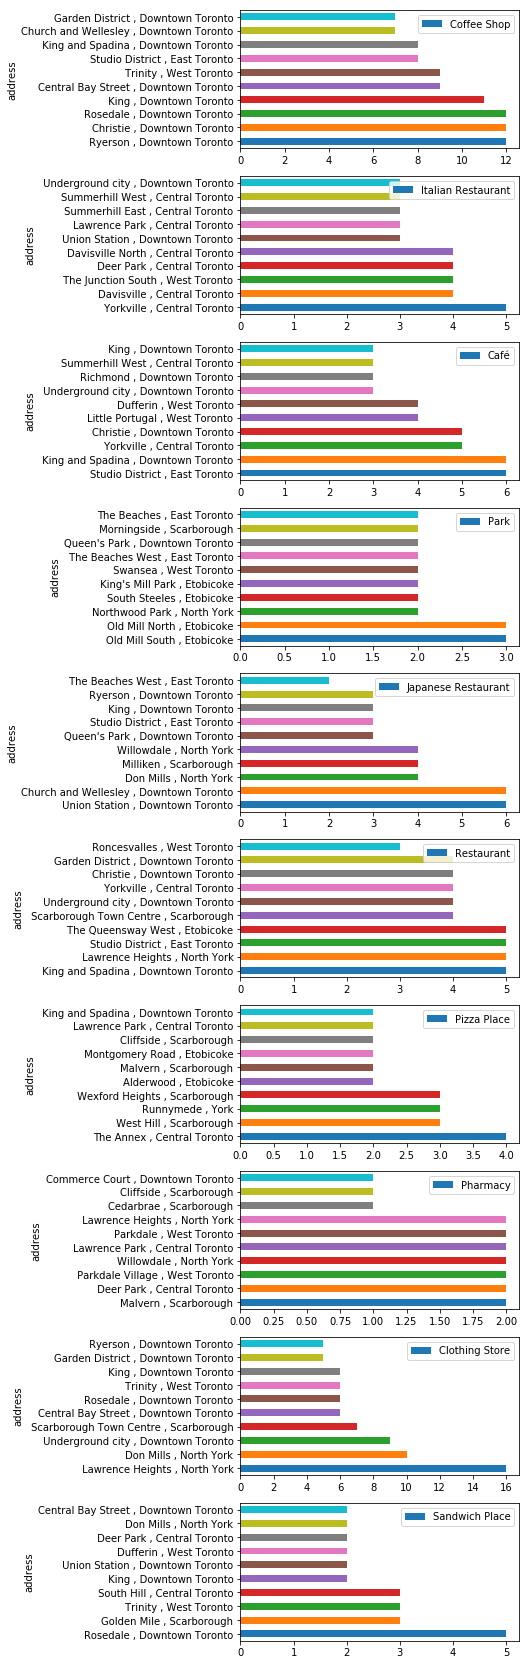

In [33]:
fig, axes = plt.subplots(10,1)
fig.set_figheight(30)
fig.set_figwidth(30)
n = 0
for ven in top10_venues:
    df_10ven_neigh.sort_values(ven , ascending=False).head(10).plot(kind = 'barh' , x ='address' , y = ven , rot = 0 , ax = axes[n] , figsize = (5,30) )
    n += 1
plt.show()

Same way, we can find neighborhoods with the lowest number of stores in the top 10 categories. This way, we can find neighborhoods with higher potential for successful investment.

In [34]:
test = {}
for ven in top10_venues:
    test[ven] = df_10ven_neigh.sort_values(ven , ascending=False).tail(20)['Neighborhood'].values.tolist()
pd.DataFrame(test)

,Coffee Shop,Italian Restaurant,Café,Park,Japanese Restaurant,Restaurant,Pizza Place,Pharmacy,Clothing Store,Sandwich Place
0,Bayview Village,The Junction North,Clarks Corners,Garden District,Summerhill East,Agincourt,Sunnylea,L'Amoreaux West,Mount Dennis,Highland Creek
1,Golden Mile,Tam O'Shanter,Union Station,Forest Hill North & West,Old Mill North,York University,Sullivan,Lawrence Manor East,Mount Olive,Island airport
2,Guildwood,Oriole,Thistletown,L'Amoreaux East,Rouge,Tam O'Shanter,Steeles East,Maple Leaf Park,Newtonbrook,Agincourt
3,High Park,Swansea,Richview Gardens,Fairview,Oriole,Woodbine Gardens,South Niagara,Markland Wood,North Midtown,Yorkville
4,Swansea,Parkdale Village,St. Phillips,L'Amoreaux West,Port Union,Island airport,Mount Olive,Clarks Corners,Oakridge,Kingsway Park South East
5,New Toronto,Port Union,Rouge,Lawrence Heights,Princess Gardens,The Junction North,North Midtown,Church and Wellesley,Old Burnhamthorpe,The Junction North
6,Moore Park,Princess Gardens,Scarborough Town Centre,Don Mills,Rathnelly,The Junction South,Oakridge,Christie,Old Mill North,The Junction South
7,Mimico NW,Richview Gardens,Scarborough Village West,Birch Cliff,Richview Gardens,The Queensway East,Old Burnhamthorpe,Central Bay Street,Ontario Provincial Government,The Queensway East
8,Maple Leaf Park,Riverdale,Silver Hills,Martin Grove,Riverdale,Ionview,Old Mill North,Mimico NE,Oriole,The Queensway West
9,Birch Cliff,Rouge,Silverstone,Martin Grove Gardens,Roncesvalles,Thistletown,Ontario Provincial Government,Brockton,Parkdale Village,Thistletown


### 4.2 Analyze data based on Borough
In this section, we group venues of the neighborhoods based on the borough they belong to. Then we plot the number of top venues in each borough. 

In [35]:
Boroughs = CanPostCode["Borough"].unique().tolist()
Boroughs

['North York',
 'Downtown Toronto',
 'Etobicoke',
 'Scarborough',
 'East York',
 'York',
 'East Toronto',
 'West Toronto',
 'Central Toronto']

In [36]:
#### UNCOMMENT IF RUN FOR THE FIRST TIME #### AND THEN COMMENT OUT THE WHOLE CELL
#dic_test = {}
#for brgh in Boroughs:
#    print(brgh)
#    brgh_df = CanPostCode[CanPostCode["Borough"] == brgh].reset_index(drop=True)
#    brgh_venues = getNearbyVenues(names=brgh_df['Neighborhood'],
#                                   latitudes=brgh_df['lat'],
#                                   longitudes=brgh_df['long']
#                                  )
#    dic_test[brgh] = brgh_venues.groupby('Venue Category').count().sort_values("Neighborhood" , ascending=False)

In [37]:
#### UNCOMMENT IF RUN FOR THE FIRST TIME #### AND THEN COMMENT OUT THE WHOLE CELL
## with open('Borough_venue.pkl', 'wb') as b_v:
##        pickle.dump(dic_test, b_v)        

In [38]:
####
with open('Borough_venue.pkl', 'rb') as b_v:
        dic_test = pickle.load(b_v)

In [39]:
dict_10ven_bor = {}
for ven in top10_venues:
    dict_10ven_bor[ven] = {}
    for bor in Boroughs:
        try:
            dict_10ven_bor[ven][bor] = toronto_venues.groupby(['Borough','Venue Category']).count().loc[bor].loc[ven , 'Venue']
        except:    
            dict_10ven_bor[ven][bor] = 0
            
df_10ven_bor = pd.DataFrame(dict_10ven_bor)
df_10ven_bor.reset_index(inplace = True) 
df_10ven_bor.rename(columns = {"index" : "Borough"} , inplace = True)

In [40]:
df_10ven_bor

,Borough,Coffee Shop,Italian Restaurant,Café,Park,Japanese Restaurant,Restaurant,Pizza Place,Pharmacy,Clothing Store,Sandwich Place
0,Central Toronto,33,33,23,13,8,7,17,13,5,10
1,Downtown Toronto,123,77,56,35,55,28,12,26,45,17
2,East Toronto,17,7,12,7,9,7,2,6,0,4
3,East York,9,4,1,4,3,2,4,5,0,3
4,Etobicoke,45,18,15,19,6,14,20,18,1,7
5,North York,39,4,5,16,9,17,9,8,26,13
6,Scarborough,28,1,1,12,8,13,23,14,15,15
7,West Toronto,24,7,21,9,5,14,7,4,7,7
8,York,11,8,5,7,4,0,7,6,0,2


In [41]:
toronto_venues.head()

,Borough,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,North York,Parkwoods,43.761124,-79.324059,Allwyn's Bakery,43.759840,-79.324719,Caribbean Restaurant
1,North York,Parkwoods,43.761124,-79.324059,Tim Hortons,43.760668,-79.326368,Café
2,North York,Parkwoods,43.761124,-79.324059,A&W,43.760643,-79.326865,Fast Food Restaurant
3,North York,Parkwoods,43.761124,-79.324059,Food Basics,43.760549,-79.326045,Supermarket
4,North York,Parkwoods,43.761124,-79.324059,Shoppers Drug Mart,43.760857,-79.324961,Pharmacy


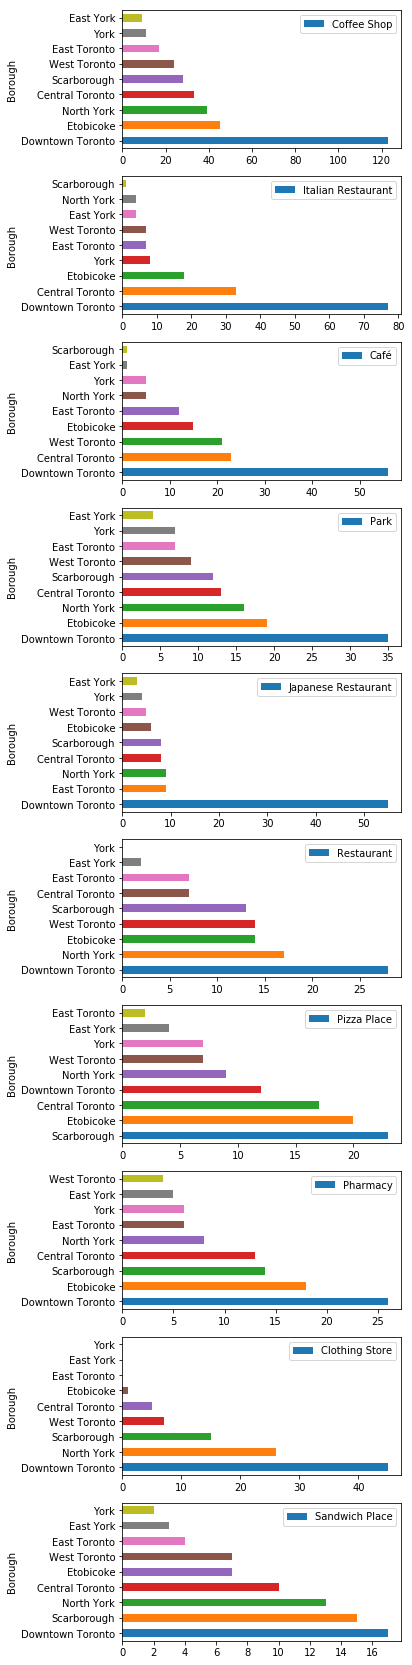

In [42]:
fig3, axes3 = plt.subplots(10,1)
fig3.set_figheight(30)
fig3.set_figwidth(30)
n = 0
for ven in top10_venues:
    df_10ven_bor.sort_values(ven , ascending=False).head(9).plot(kind = 'barh' , x ='Borough' , y = ven , rot = 0 , ax = axes3[n] , figsize = (5,30) )
    n += 1
plt.show()

This information enables investors to make better investing decisions. 

#### 4.2.1 Boroughs' food diversity 
In this section, we narrow the type of venues down to the different food categories. This way, we can analyze the diversity of each borough based on the variety of popular food categories.

In [43]:
food_categories = ['Pizza Place' , 'Sandwich Place' , 'Fast Food Restaurant' , 'Japanese Restaurant' ,
                  'Italian Restaurant' , 'Vietnamese Restaurant' , 'Sushi Restaurant' , 'Korean Restaurant' , 
                   'Thai Restaurant'  , 'American Restaurant',
                  'Ramen Restaurant' , 'Indian Restaurant' , 'Steakhouse' , 'Seafood Restaurant',
                  'Chinese Restaurant' , 'Burrito Place' , 'Middle Eastern Restaurant' , 'Greek Restaurant' ,
                  'Asian Restaurant' , 'Fried Chicken Joint' , 'Burger Joint' , 'New American Restaurant' ,'Falafel Restaurant',
                  'Caribbean Restaurant' , 'BBQ Joint' , 'Vegetarian / Vegan Restaurant' , 'Turkish Restaurant' ]

In [44]:
toronto_venues_food = toronto_venues[toronto_venues['Venue Category'].isin(food_categories)]
toronto_venues_food.head()

,Borough,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,North York,Parkwoods,43.761124,-79.324059,Allwyn's Bakery,43.759840,-79.324719,Caribbean Restaurant
2,North York,Parkwoods,43.761124,-79.324059,A&W,43.760643,-79.326865,Fast Food Restaurant
5,North York,Parkwoods,43.761124,-79.324059,Pizza Pizza,43.760231,-79.325666,Pizza Place
10,North York,Parkwoods,43.761124,-79.324059,Spicy Chicken House,43.760639,-79.325671,Chinese Restaurant
12,North York,Victoria Village,43.732658,-79.311189,Armenian Kitchen,43.731071,-79.305390,Middle Eastern Restaurant


In [45]:
top5_venues_food = toronto_venues_food.groupby('Venue Category')['Venue Category'].count().sort_values(ascending=False).head(5).keys().values.tolist()
top5_venues_food

['Italian Restaurant',
 'Japanese Restaurant',
 'Pizza Place',
 'Sandwich Place',
 'Fast Food Restaurant']

### 4.2.2 Boroughs and top 5 restaurant categories

In the previous section, we found the top ten restaurant categories in Toronto. Now we are going to calculate **how many of each of these top 10 popular restaurants of Toronto are located in each borough**.

In [47]:
dict_5food_bor = {}
for ven in top5_venues_food:
    dict_5food_bor[ven] = {}
    for bor in Boroughs:
        try:
            dict_5food_bor[ven][bor] = toronto_venues_food.groupby(['Borough','Venue Category']).count().loc[bor].loc[ven , 'Venue']
        except:    
            dict_5food_bor[ven][bor] = 0
            
df_5food_bor = pd.DataFrame(dict_5food_bor)
df_5food_bor.reset_index(inplace = True) 
df_5food_bor.rename(columns = {"index" : "Borough"} , inplace = True)

In [48]:
df_5food_bor

,Borough,Italian Restaurant,Japanese Restaurant,Pizza Place,Sandwich Place,Fast Food Restaurant
0,Central Toronto,33,8,17,10,2
1,Downtown Toronto,77,55,12,17,14
2,East Toronto,7,9,2,4,3
3,East York,4,3,4,3,1
4,Etobicoke,18,6,20,7,9
5,North York,4,9,9,13,14
6,Scarborough,1,8,23,15,29
7,West Toronto,7,5,7,7,5
8,York,8,4,7,2,0


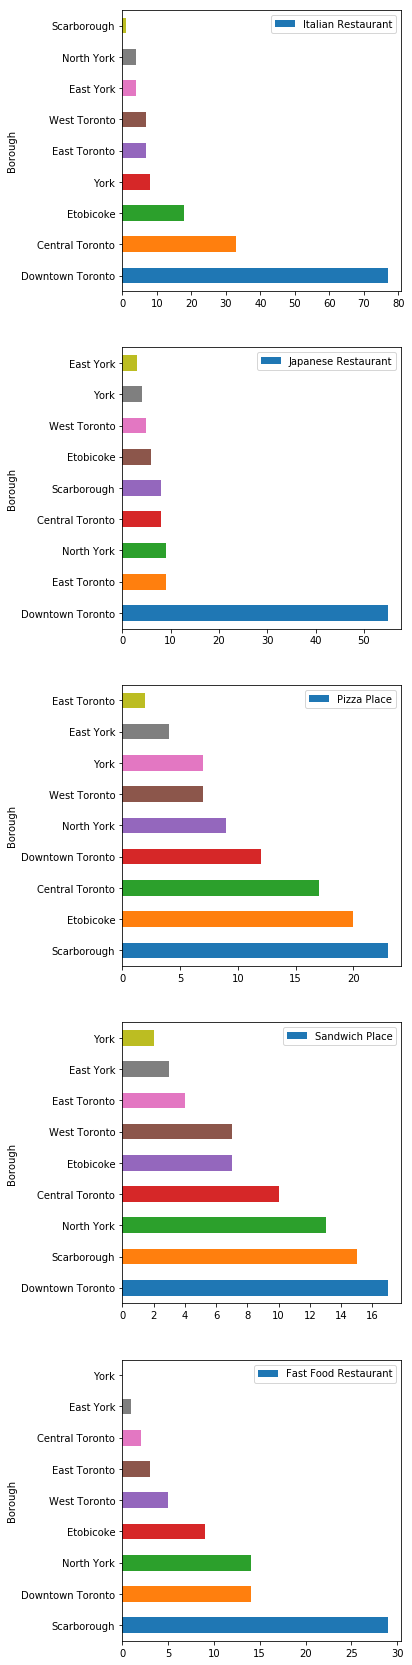

In [50]:
fig4, axes4 = plt.subplots(5,1)
fig4.set_figheight(30)
fig4.set_figwidth(30)
n = 0
for ven in top5_venues_food:
    df_5food_bor.sort_values(ven , ascending=False).head(10).plot(kind = 'barh' , x ='Borough' , y = ven , rot = 0 , ax = axes4[n] , figsize = (5,30) )
    n += 1
plt.show()

In [51]:
df_5food_bor.set_index('Borough' , inplace = True)
df_5food_bor

,Italian Restaurant,Japanese Restaurant,Pizza Place,Sandwich Place,Fast Food Restaurant
Borough,,,,,
Central Toronto,33,8,17,10,2
Downtown Toronto,77,55,12,17,14
East Toronto,7,9,2,4,3
East York,4,3,4,3,1
Etobicoke,18,6,20,7,9
North York,4,9,9,13,14
Scarborough,1,8,23,15,29
West Toronto,7,5,7,7,5
York,8,4,7,2,0


## Cluster Boroughs
k-means clustering is a simple but useful and popular, unsupervised machine learning algorithm that is used to categorized data into clusters. The clustered data share some similar characteristics. We use this algorithm to cluster similar boroughs and find out which boroughs share the same characteristics and how.

Determining the optimal number of clusters in this method is a frequent problem in data clustering. The optimal number of clusters can be achieved by *The Elbow Method* or *The Silhouette Method*.

**The elbow method** runs k-means clustering for a range of different values of k, and for each value of k, it computes an average score for all clusters.

1 2 3 4 5 6 7 

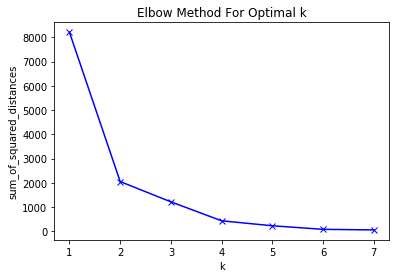

In [52]:
sum_of_squared_distances = []
K = range(1,8)
for k in K:
    print(k, end=' ')
    kmeans = KMeans(n_clusters=k , init = 'random').fit(df_5food_bor)
    sum_of_squared_distances.append(kmeans.inertia_)
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('sum_of_squared_distances')
plt.title('Elbow Method For Optimal k');

Apprantly, Elbow Method does not reveal any useful information about the optimal number of clusters. Therefore, we use the other method.

**The Silhouette Method**  examines how well a data point lies within its cluster compared to the other clusters.

2 3 4 5 6 7 8 

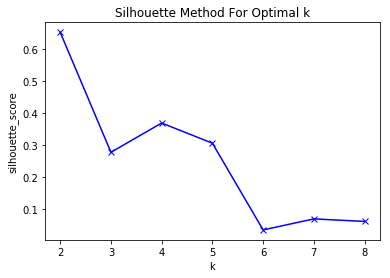

In [53]:
sil = []
K_sil = range(2,9)
# minimum 2 clusters required, to define dissimilarity
for k in K_sil:
    print(k, end=' ')
    kmeans = KMeans(n_clusters = k , init = 'random').fit(df_5food_bor)
    labels = kmeans.labels_
    sil.append(silhouette_score(df_5food_bor, labels, metric = 'euclidean'))
plt.plot(K_sil, sil, 'bx-')
plt.xlabel('k')
plt.ylabel('silhouette_score')
plt.title('Silhouette Method For Optimal k')
plt.show()

Since k = 2 shows a very poor performance with broad classification, we select k = 4 as there is a peak at k =4.

In [54]:
# set number of clusters
kclusters = 4

# run k-means clustering
kmeans = KMeans(init="random", n_clusters=kclusters,  ).fit(df_5food_bor)

print(Counter(kmeans.labels_))
kmeans.labels_

Counter({2: 5, 0: 2, 1: 1, 3: 1})


array([0, 1, 2, 2, 0, 2, 3, 2, 2], dtype=int32)

Now we add the cluster column to the dataframe that shows cluster number of each Borough.

In [55]:
# add clustering labels
try: 
    df_5food_bor.drop('Cluster', axis=1)
except:
    df_5food_bor.insert(0, 'Cluster', kmeans.labels_)

In [57]:
df_5food_bor.sort_values(['Cluster'])    

,Cluster,Italian Restaurant,Japanese Restaurant,Pizza Place,Sandwich Place,Fast Food Restaurant
Borough,,,,,,
Central Toronto,0,33,8,17,10,2
Etobicoke,0,18,6,20,7,9
Downtown Toronto,1,77,55,12,17,14
East Toronto,2,7,9,2,4,3
East York,2,4,3,4,3,1
North York,2,4,9,9,13,14
West Toronto,2,7,5,7,7,5
York,2,8,4,7,2,0
Scarborough,3,1,8,23,15,29


### Analysing differet groups:

#### Group 1 - Etobicoke, Central Toronto: Italian and Pizza
#### Group 2 - Downtown Toronto
As expected, There are many restaurants of different types in Downtown Toronto.
#### Group 3 - East Toronto,West Toronto, East York, North York , York: Italian
#### Group 4- Scarborough:  Fast Food, Pizza, Sandwich


In [60]:
df_5food_bor.reset_index(inplace = True)
Cluster_Borough = pd.Series(df_5food_bor.Cluster.values,index=df_5food_bor.Borough).to_dict()

The plot of Toronto with all its neighborhoods is shown at the beginning of this notebook. Now, we plot that map again but this time we match colors of neighborhoods whose Boroughs fall into the same category. 

In [61]:
# set color scheme for the clusters
colors_array = cm.rainbow(np.linspace(0, 1, kclusters+1)) # plus one because of Mississauga
rainbow = [colors.rgb2hex(i) for i in colors_array]

rainbow = ['red' , 'blue' , 'green' , 'yellow' , 'white' , 'black']
# create map of Toronto using latitude and longitude values
latitude = 43.6534817
longitude = -79.3839347
map_tor = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood ,  in zip(CanPostCode['lat'], CanPostCode['long'], CanPostCode['Borough'], CanPostCode['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    cluster = Cluster_Borough[borough]
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_tor) 
    
map_tor

### 4.2.2 Top five restaurants in each Borough

In the previous section, we examined the Boroughs against the top five popular restaurants in Toronto. Since the restaurants' concentration varies based on location, we explore the top five restaurants in each Borough. This gives us a better understanding on how diverse each area is.

In [62]:
dict_Bor_5food = {}
for brgh in Boroughs:
    temp = dic_test[brgh].reset_index()
    if len(temp[temp['Venue Category'].isin(food_categories)].reset_index()['Venue Category'].tolist()) >= 5:
        dict_Bor_5food[brgh] = temp[temp['Venue Category'].isin(food_categories)].reset_index()['Venue Category'].head(5).tolist()
    dict_Bor_5food

In [63]:
Bor_5food_df = pd.DataFrame.from_dict(dict_Bor_5food , orient='index')
Bor_5food_df.rename(columns = {0: '1st most common' , 1: '2nd most common' , 2: '3rd most common' , 3: '4th most common' ,
                              4 : '5th most common'})

,1st most common,2nd most common,3rd most common,4th most common,5th most common
North York,Fast Food Restaurant,Sandwich Place,Pizza Place,Japanese Restaurant,Middle Eastern Restaurant
Downtown Toronto,Italian Restaurant,Japanese Restaurant,Middle Eastern Restaurant,Thai Restaurant,Sandwich Place
Etobicoke,Pizza Place,Italian Restaurant,Sushi Restaurant,Indian Restaurant,Fast Food Restaurant
Scarborough,Fast Food Restaurant,Pizza Place,Chinese Restaurant,Sandwich Place,Japanese Restaurant
East York,Pizza Place,Italian Restaurant,Indian Restaurant,Japanese Restaurant,Sandwich Place
York,Italian Restaurant,Pizza Place,Japanese Restaurant,Fried Chicken Joint,Sandwich Place
East Toronto,Japanese Restaurant,Italian Restaurant,Thai Restaurant,Seafood Restaurant,Vietnamese Restaurant
West Toronto,Vietnamese Restaurant,Italian Restaurant,Sandwich Place,Pizza Place,Thai Restaurant
Central Toronto,Italian Restaurant,Sushi Restaurant,Pizza Place,Thai Restaurant,Sandwich Place


### Cluster Boroughs

We need get_dummies to convet the categorical variable to indicator variables so we can analyse them with k-means clustering method.

In [67]:
toronto_onehot = pd.get_dummies(Bor_5food_df)
toronto_onehot

,0_Fast Food Restaurant,0_Italian Restaurant,0_Japanese Restaurant,0_Pizza Place,0_Vietnamese Restaurant,1_Italian Restaurant,1_Japanese Restaurant,1_Pizza Place,1_Sandwich Place,1_Sushi Restaurant,2_Chinese Restaurant,2_Indian Restaurant,2_Japanese Restaurant,2_Middle Eastern Restaurant,2_Pizza Place,2_Sandwich Place,2_Sushi Restaurant,2_Thai Restaurant,3_Fried Chicken Joint,3_Indian Restaurant,3_Japanese Restaurant,3_Pizza Place,3_Sandwich Place,3_Seafood Restaurant,3_Thai Restaurant,4_Fast Food Restaurant,4_Japanese Restaurant,4_Middle Eastern Restaurant,4_Sandwich Place,4_Thai Restaurant,4_Vietnamese Restaurant
North York,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0
Downtown Toronto,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0
Etobicoke,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0
Scarborough,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0
East York,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
York,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
East Toronto,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1
West Toronto,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
Central Toronto,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0


We are going to take exact same steps that we took in the previous section to find the optimal number of clusters.

In [69]:
sum_of_squared_distances = []
K = range(1,10)
for k in K:
    print(k, end=' ')
    kmeans = KMeans(n_clusters=k).fit(toronto_onehot)
    sum_of_squared_distances.append(kmeans.inertia_)

1 2 3 4 5 6 7 8 9 

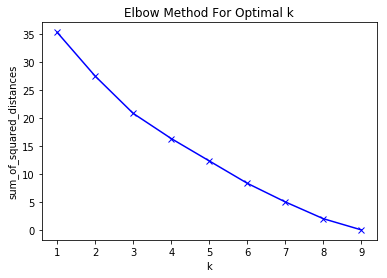

In [70]:
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('sum_of_squared_distances')
plt.title('Elbow Method For Optimal k');

In [71]:
sil = []
K_sil = range(2,9)
# minimum 2 clusters required, to define dissimilarity
for k in K_sil:
    print(k, end=' ')
    kmeans = KMeans(n_clusters = k).fit(toronto_onehot)
    labels = kmeans.labels_
    sil.append(silhouette_score(toronto_onehot, labels, metric = 'euclidean'))

2 3 4 5 6 7 8 

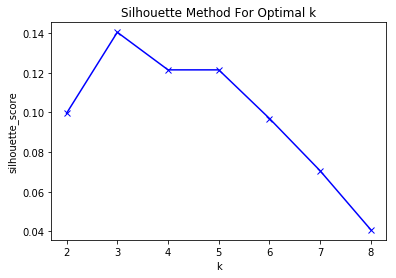

In [72]:
plt.plot(K_sil, sil, 'bx-')
plt.xlabel('k')
plt.ylabel('silhouette_score')
plt.title('Silhouette Method For Optimal k')
plt.show()


In [73]:
# set number of clusters
kclusters = 3

# run k-means clustering
kmeans = KMeans(init="k-means++", n_clusters=kclusters, n_init=50).fit(toronto_onehot)

print(Counter(kmeans.labels_))

Counter({1: 4, 2: 3, 0: 2})


In [74]:
# add clustering labels
try:
    Bor_5food_df.drop('Cluster', axis=1)
except:
    Bor_5food_df.insert(0, 'Cluster', kmeans.labels_)

In [75]:
Bor_5food_df.reset_index(inplace = True)

In [76]:
Bor_5food_df.rename(columns = {'index' : 'Borough'} , inplace = True)

In [77]:
Bor_5food_df.sort_values(['Cluster'])

,Borough,Cluster,0,1,2,3,4
0,North York,0,Fast Food Restaurant,Sandwich Place,Pizza Place,Japanese Restaurant,Middle Eastern Restaurant
3,Scarborough,0,Fast Food Restaurant,Pizza Place,Chinese Restaurant,Sandwich Place,Japanese Restaurant
2,Etobicoke,1,Pizza Place,Italian Restaurant,Sushi Restaurant,Indian Restaurant,Fast Food Restaurant
4,East York,1,Pizza Place,Italian Restaurant,Indian Restaurant,Japanese Restaurant,Sandwich Place
6,East Toronto,1,Japanese Restaurant,Italian Restaurant,Thai Restaurant,Seafood Restaurant,Vietnamese Restaurant
7,West Toronto,1,Vietnamese Restaurant,Italian Restaurant,Sandwich Place,Pizza Place,Thai Restaurant
1,Downtown Toronto,2,Italian Restaurant,Japanese Restaurant,Middle Eastern Restaurant,Thai Restaurant,Sandwich Place
5,York,2,Italian Restaurant,Pizza Place,Japanese Restaurant,Fried Chicken Joint,Sandwich Place
8,Central Toronto,2,Italian Restaurant,Sushi Restaurant,Pizza Place,Thai Restaurant,Sandwich Place


### Group one: North York, Scarborough: Fast Food, Pizza, Sandwich
### Group two: Etobicoke, East York, East Toronto, West Toronto: Italian
### Group three: Downtown Toronto, York, Central Toronto: Italian, Sandwich

We plot map of toronto while all the neighborhoods are colored based on their Boroughs' clusters. 

In [78]:
Cluster_Borough = pd.Series(Bor_5food_df.Cluster.values,index=Bor_5food_df.Borough).to_dict()
Cluster_Borough
# set color scheme for the clusters
colors_array = cm.rainbow(np.linspace(0, 1, kclusters+1)) # plus one because of Mississauga
rainbow = [colors.rgb2hex(i) for i in colors_array]

rainbow = ['red' , 'blue' , 'green' , 'yellow' , 'white' , 'black']
# create map of Toronto using latitude and longitude values
latitude = 43.6534817
longitude = -79.3839347
map_tor = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood ,  in zip(CanPostCode['lat'], CanPostCode['long'], CanPostCode['Borough'], CanPostCode['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    cluster = Cluster_Borough[borough]
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_tor) 
    
map_tor

## Thanks for reading!
If you have any questions, you can contact me on 